In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import json 
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import pickle

import keras

from laneDetectionHelperFunctions import *
import random
from CNNModel import cnn_model

Using TensorFlow backend.


In [2]:
LOWER_LEFT_POINT = [0, 80]
UPPER_LEFT_POINT = [0, 40]
UPPER_RIGHT_POINT = [160, 30]
LOWER_RIGHT_POINT = [160, 80]
VERTICES = np.array([[LOWER_LEFT_POINT, UPPER_LEFT_POINT, UPPER_RIGHT_POINT, LOWER_RIGHT_POINT]], dtype=np.int32)

# Load Tusimple train images and generate labels

In [3]:
try:
    tusimple_train_images = pickle.load(open("tusimple_train_images.p", "rb" ))
    tusimple_labels = pickle.load(open("tusimple_labels.p", "rb" ))
except:
    tusimple_train_images = []
    tusimple_labels = []
    json_gt = [json.loads(line) for line in open('label_data_0313.json')]
    json_gt = json_gt + [json.loads(line) for line in open('label_data_0531.json')]
    json_gt = json_gt + [json.loads(line) for line in open('label_data_0601.json')]
    for gt in json_gt:
        # Get image
        image = cv2.imread(gt['raw_file'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_image = cv2.resize(image, (160, 80), interpolation = cv2.INTER_AREA)
        tusimple_train_images.append(resize_image)
        # Generate label
        gt_lanes = gt['lanes']
        y_samples = gt['h_samples']
        gt_lanes_vis = [[(x,y) for (x,y) in zip(lane,y_samples) if x >= 0] for lane in gt_lanes]
        label = get_label(image, gt_lanes_vis, 5)

        resize_label = cv2.resize(label, (160, 80), interpolation = cv2.INTER_AREA)
        reshape_label = np.zeros((80, 160, 1))
        reshape_label[:, :, 0] = resize_label[:,:]
        tusimple_labels.append(reshape_label)

    pickle.dump(tusimple_train_images, open("tusimple_train_images.p", "wb") )
    pickle.dump(tusimple_labels, open("tusimple_labels.p", "wb"))

## Visualisee Tusimple data and its corresponding labels

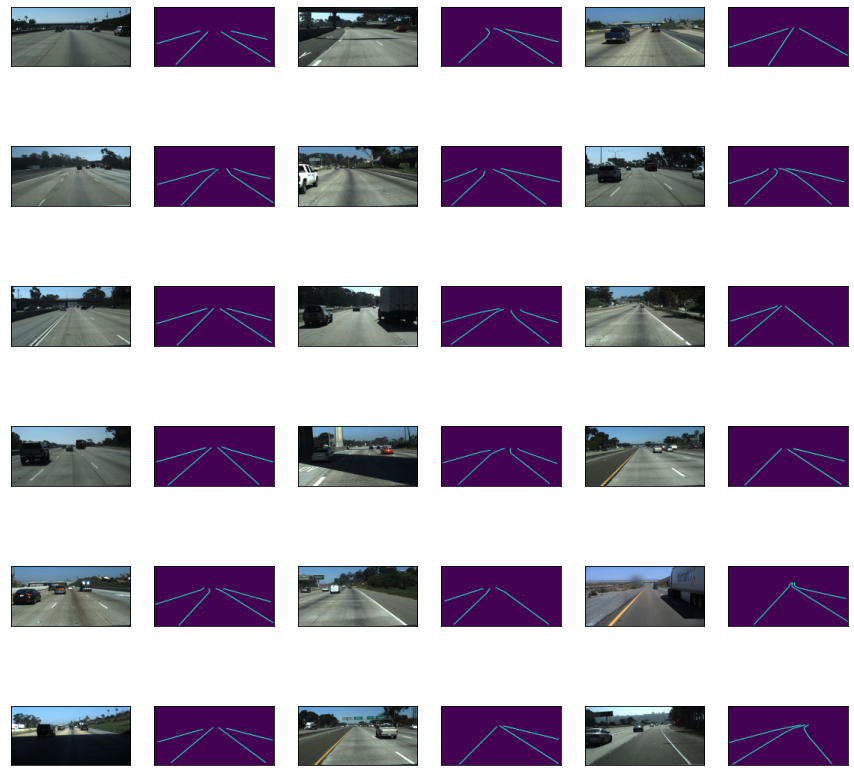

In [4]:
visualize_data_and_label(tusimple_train_images, tusimple_labels)

# Get ready for training CNN model

## Preprocess training image (iamge &rarr; gray-scale &rarr; remove noise &rarr; detect edge &rarr; roi)

In [5]:
pre_process_train_images = [region_of_interest(pre_process(img), VERTICES) for img in tusimple_train_images]

## Visualisee preprocessed training images and its corresponding labels

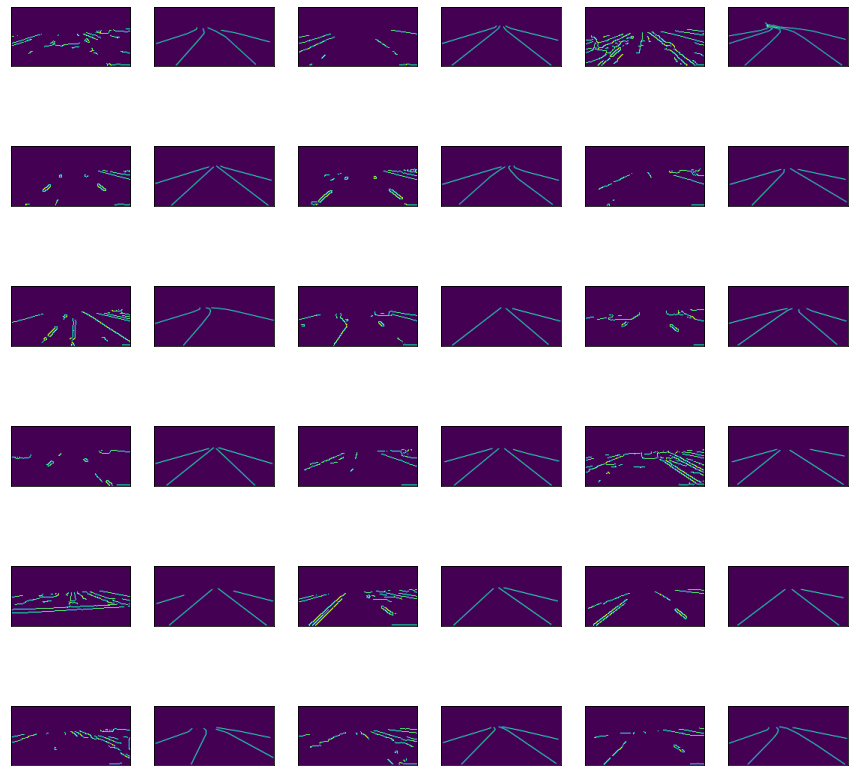

In [6]:
visualize_data_and_label(pre_process_train_images, tusimple_labels)

In [7]:
train_images = []
for img in pre_process_train_images:
    reshape_img = reshape_2D_to_3D(img)
    train_images.append(reshape_img)

In [8]:
train_images = np.array(train_images)
labels = np.array(tusimple_labels)
# normalise labels
labels = labels/255

## Train CNN model

In [9]:
try:
    model = keras.models.load_model('CNN_model.h5')
except:
    train_images, labels = shuffle(train_images, labels)
    # Test size may be 10% or 20%
    X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

    # Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
    batch_size = 128
    epochs = 10
    pool_size = (2, 2)
    input_shape = X_train.shape[1:]

    # Create the neural network
    model = cnn_model(input_shape, pool_size)

    # Using a generator to help the model use less data
    # Channel shifts help with shadows slightly
    datagen = ImageDataGenerator(channel_shift_range=0.2)
    datagen.fit(X_train)

    # Compiling and training the model
    model.compile(optimizer='Adam', loss='mean_squared_error')
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
    epochs=epochs, verbose=1, validation_data=(X_val, y_val))


    # Freeze layers since training is done
    model.trainable = False
    model.compile(optimizer='Adam', loss='mean_squared_error')

    # Save model architecture and weights
    model.save('CNN_model.h5')

    # Show summary of model 
    model.summary()